頑張って！<br>
<img src="frieren.JPG" alt="frieren" width="100" height="100" style="float:left;border: 1px solid black">

### 采用了sobel采样的准随机数生成种群，并且探索方式变为朝着单一蜜源历史最佳和种群最佳方向探索。

In [9]:
# Author: Bian Hanzhang

"""import packages"""
import random as rand
from copy import deepcopy
# import time
# from math import floor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import MultipleLocator
from scipy.stats import qmc

In [101]:
# read file
FILE_NAME = "/Users/bianhanzhang/Desktop/Coding/MY-ABC/data/asset pool/SP500_100_assets_pool2.csv"
data = pd.read_csv(FILE_NAME)
data.head(3)

,mean_return,MO,BLL,NTAP,AFL,AAP,SRE,MGM,DHI,AON,...,LH,INCY,ALB,TROW,PFE,HP,BEN,EA,NSC,ECL
0,0.001138,0.000102,0.000058,0.000071,0.000040,0.000037,0.000035,0.000049,0.000049,0.000062,...,0.000053,0.000039,0.000043,0.000026,0.000030,0.000052,0.000043,0.000075,0.000048,0.000031
1,-0.000027,0.000058,0.000216,0.000172,0.000069,0.000120,0.000053,0.000093,0.000088,0.000180,...,0.000102,0.000101,0.000072,0.000066,0.000041,0.000124,0.000082,0.000197,0.000118,0.000051
2,0.000937,0.000071,0.000172,0.000312,0.000080,0.000142,0.000044,0.000112,0.000101,0.000198,...,0.000120,0.000113,0.000081,0.000076,0.000011,0.000124,0.000098,0.000230,0.000114,0.000032


In [3]:
# mean return of 100 selected bonds
SP_mean_rtn = np.reshape(np.array(data.iloc[:,0]),(100,1))

# covariance of 100 selected bonds
SP_cov_rtn = np.array(data.iloc[:,1:])

In [22]:
class ParameterInformation:
    """
    Store algorithm's parameters:
    - population: amount of bees = employed bees = onlooking bees
    - dimension: number of genes in a chromosome
    - max_bound: upper bound of one gene on chromosome
    - min_bound: lower bound of one gene on chromosome
    - max_iter_num: max iteration times of each nectar
    - algo_iter_num: current iteration times of the algorithm 
    - algo_max_iter_num: max iteration times of the algorithm
    - risk_averse_para: risk aversion parameter of investor
    - cardinality: number of assets included in the portfolio
    - SPP: scout production cycle
    """

    def __init__(self, population, dimension, min_bound, max_bound, max_iter_num,
                 algo_max_iter_num, risk_averse_para, cardinality, SPP):
        self.population = population
        self.dimension = dimension
        self.max_bound = max_bound
        self.min_bound = min_bound
        self.max_iter_num = max_iter_num
        self.algo_iter_num = 0  # Initialize to 0 as the algorithm hasn't started
        self.algo_max_iter_num = algo_max_iter_num
        self.risk_averse_para = risk_averse_para
        self.cardinality = cardinality
        self.SPP = SPP

    def set_algo_iter_num(self, value):
        """Set algorithm's iteration number"""
        self.algo_iter_num = value

    def show_parameter(self):
        """Show parameter"""
        print("Parameter Information:")
        print(f"Population: {self.population}")
        print(f"Dimension: {self.dimension}")
        print(f"Bounds: [{self.min_bound}, {self.max_bound}]")
        print(f"Cardinality: {self.cardinality}")
        print(f"Max Iter Num: {self.max_iter_num}")
        print(f"Algo Max Iter Num: {self.algo_max_iter_num}")
        print(f"Risk Averse Parameter: {self.risk_averse_para}")

***
### log_Nectar
1.random_直接用随机生成0，1是否更快 <br>
2.已将class级的变量删除 <br>
3.染色体初始化为0 array <br>
4.限定了dv为int <br>

In [59]:
class Nectar:
    """nectar(chromosome) information"""

    def __init__(self, dimension) -> None:
        """initialize chromosome and decision variable"""
        self.chromosome = np.zeros(dimension)
        self.dv = np.zeros(dimension, dtype=int)
        self.fitness = 0
        self.test_func_value = 0
        self.iter_num = 0
        self.select_probability = 0
        self.best_chromosome = np.zeros(dimension)
        self.best_dv = np.zeros(dimension, dtype=int)
        self.best_test_value = 999

    def set_chromosome(self, i, value):
        """set one position of the chromosome"""
        self.chromosome[i] = value
        
    def set_chromosome_all(self,new_chromosome):
        self.chromosome = new_chromosome

    def random_chromosome(self, min_bound, max_bound, dimension):
        """randomly generate a chromosome"""
        self.chromosome = np.random.uniform(min_bound, max_bound, dimension)
        
    def set_dv(self, i, value):
        """set one position of decision variable"""
        self.dv[i] = value
    
    def random_dv(self, dimension):
        """randomly generate the decision variable"""
        rnd = np.random.uniform(0, 1, dimension)
        self.dv = np.where(rnd < 0.5, 0, 1)

    def set_fitness(self, value):
        """set fitness of the nectar"""
        self.fitness = value

    def set_test_func_value(self, value):
        """set value of test function"""
        self.test_func_value = value

    def set_iter_num(self, value):
        """set number of times this nectar has been explored"""
        self.iter_num = value

    def set_select_probability(self, value):
        """set probability calculated by roulette"""
        self.select_probability = value
        
    def save_best(self):
        if self.test_func_value < self.best_test_value:
            self.best_chromosome = deepcopy(self.chromosome)
            self.best_dv = deepcopy(self.dv)

### CCMV model 
s.t.<br>
(1) weight constraint <br>
(2) cardinality constraint <br>
(3) quantity constraint <br>
(4) 0-1 constraint <br>
<img src="CCMV_model.png" alt="explanation of CCMV" style="float:left; height:200px; width:auto; border:1px solid black">

In [102]:
### fix:修正目标函数计算中的x为dv=1对应的资产，并且进行了归一化

# modeling 
def mean_variance(x, dv, mean_rtn, cov_rtn, risk_averse_para) -> float:
    """calculate objective function value"""
    
    # if decision variable is 0, set x = 0
    x[dv == 0] = 0
    
    # normalization
    total_weight = np.sum(x)
    if total_weight == 0:
        raise ValueError("Sum of weight is zero!")
    x = x/total_weight
    
    # objective function
    portfolio_variance = np.dot(np.dot(x.T, cov_rtn), x)
    portfolio_return = np.dot(x.T, mean_rtn)
    obj_func = risk_averse_para * portfolio_variance - (1 - risk_averse_para) * portfolio_return

    return obj_func


def cal_fitness(obj_value) -> float:
    """calculate fitness value by obj_value"""
    if obj_value >= 0:
        fitness = 1 / (1 + obj_value)
    else:
        fitness = 1 + abs(obj_value)
    return fitness

#####  /need fix/ fixed
#####  制约违反修改为Cardinality制约的违反程度

def cal_violation(chromosome,dv,parameter):
    """calculate violation of solution vector"""
    weights =  chromosome[np.where(dv == 1)]
    violation = np.where(weights > parameter.max_bound, weights - parameter.max_bound,0) + \
    np.where(weights < parameter.min_bound,parameter.min_bound - weights,0)
    total_violation = np.sum(violation)
    
    return total_violation

#### need fix / fixed
def deb_method(parameter,nectar,neighbor) -> bool:
    """ whether nectar will be replaced by neighbor """
    
    vio_nectar = cal_violation(nectar.chromosome,nectar.dv,parameter)
    vio_neighbor = cal_violation(neighbor.chromosome,neighbor.dv,parameter)
    if vio_nectar > 0 and vio_neighbor > 0:
        return vio_nectar > vio_neighbor
    elif vio_nectar > 0 and vio_neighbor == 0:
        return True
    elif vio_nectar == 0 and vio_neighbor > 0:
        return False
    else:
        return nectar.fitness < neighbor.fitness

#### c用来衡量资产的收益风险比率的系数，类似于sharp ratio 
<img src="c-value.png" alt="explanation of c" style="float:left; height:200px; width:auto; border:1px solid black">

In [25]:
# calculate c value of all assets
def calculate_c(data, parameter):
    theta = np.array([ 1 + (1 - parameter.risk_averse_para) * x for x in data.iloc[:,0]])
    phi = np.array([ 1 + parameter.risk_averse_para * sum(data.iloc[i,1:])/parameter.dimension for i in range(parameter.dimension)])
    omega =  -1 * min(0,min(theta))
    psi = -1 * min(0,min(phi))
    c = np.array([(theta[i] + omega)/(phi[i] + psi) for i in range(parameter.dimension)])
    return c

In [26]:
def highest_c(asset_selected, c):
    """select the highest c value asset that is not included in portfolio"""
    c[asset_selected] = -999
    max_val = np.max(c)
    asset_index = np.where(c == max_val)[0][0]
    return asset_index

def lowest_c(asset_selected, c):
    """选择投资组合中包含的最低 c 值资产。
    
    参数:
    asset_selected (list or ndarray): 投资组合中当前选中的资产索引。
    c (ndarray): 所有资产的 'c' 值数组。

    返回:
    int: 在选中资产中 'c' 值最低的资产索引。
    """
    # 提取选中资产的 'c' 值
    selected_c_values = c[asset_selected]
    
    # 在选中资产子集中找到最小 'c' 值的索引
    min_idx_local = np.argmin(selected_c_values)
    
    # 将子集中的局部索引转换为原始数组中的全局索引
    asset_index = asset_selected[min_idx_local]
    
    return asset_index

In [27]:
# function to randomly select a number that is different from/not in i(list or int)

def random_k(i, population):
    # 确保 i 为列表统一处理
    if isinstance(i, (int,np.integer)):
        excluded = {i}
    else:
        excluded = set(i)

    # 生成一个可能的选择列表，排除了 'excluded' 元素
    possible_choices = list(set(range(population)) - excluded)

    # 从剩余可能选择中随机选取
    return np.random.choice(possible_choices)

### Arrangement Function
两种思路：<br>
1.在每次跟随蜂迭代结束后，需要使用arrangement函数使得种群中每个解满足约束 <br>
2.arrangement函数改为修正单个蜜源的制约违反，用于探索后将不可行解变为可行解，再和原蜜源比较 ***多维情况下可能会降低多样性*** <br>
如采取思路2，计算目标函数值的时候可以不再进行normalization操作。<br>
(1)确保资产组合满足cardinality制约：移除多余，不足添加 ***已实现***<br>
(2)确保在资产组合中的资产权重和为1 ***已实现***<br> 
(3)确保每一种资产比例在最小值和最大值范围内 ***！未实现 是否需要存疑***

In [28]:
# arrangement function idea1
# 修正Cardinality制约
def arrangement1(nectar_sources, parameter, c):
    for nectar in nectar_sources:
        selected_index = np.where(nectar.dv == 1)[0].tolist()
        # print(f"selected index: {selected_index}")
        asset_num = sum(nectar.dv)
        diff = asset_num - parameter.cardinality
        # print(f"diff: {diff}")
        if diff > 0:
            # remove redundant assets
            cnt = 0
            while cnt < diff:
                random_num = np.random.uniform(0,1)
                if random_num < 0.5:
                    # randomly select an selected asset and remove from the portfolio
                    # let dv[selected]=0
                    ast_selected = np.random.choice(selected_index)
                    selected_index.remove(ast_selected)
                    nectar.set_dv(ast_selected,0)
                elif random_num >= 0.5:
                    # select the asset with lowest c-value
                    ast_selected = lowest_c(selected_index,c)
                    # print(f"type:{type(ast_selected)}")
                    selected_index.remove(ast_selected)
                    nectar.set_dv(ast_selected,0)
                cnt+=1
        elif diff < 0:
            # add assets
            cnt = 0
            diff = abs(diff)
            while cnt < diff:
                random_num = np.random.uniform(0,1)
                if random_num < 0.5:
                    # randomly select an unselected asset and put into the portfolio
                    # let dv[selected]=1
                    ast_selected = random_k(selected_index,parameter.dimension)
                    selected_index.append(ast_selected)
                    nectar.set_dv(ast_selected,1)
                elif random_num >= 0.5:
                    # select the asset with highest c-value
                    ast_selected = highest_c(selected_index,c)
                    selected_index.append(ast_selected)
                    nectar.set_dv(ast_selected,1)
                cnt+=1
                
        # Normalization for dv == 1
        weights = nectar.chromosome[nectar.dv == 1]
        sum_of_weights = np.sum(weights)
        weights = weights / sum_of_weights
        nectar.chromosome[nectar.dv == 1] = weights
        
    return nectar_sources    

In [29]:
# arrangement function ider2

def arrangement2(nectar, parameter, c):
    selected_index = np.where(nectar.dv == 1)[0].tolist()
    # print(f"selected index: {selected_index}")
    asset_num = sum(nectar.dv)
    diff = asset_num - parameter.cardinality
    # print(f"diff: {diff}")
    if diff > 0:
        # remove redundant assets
        cnt = 0
        while cnt < diff:
            random_num = np.random.uniform(0,1)
            if random_num < 0.5:
                # randomly select an selected asset and remove from the portfolio
                # let dv[selected]=0
                ast_selected = np.random.choice(selected_index)
                selected_index.remove(ast_selected)
                nectar.set_dv(ast_selected,0)
            elif random_num >= 0.5:
                # select the asset with lowest c-value
                ast_selected = lowest_c(selected_index,c)
                # print(f"type:{type(ast_selected)}")
                selected_index.remove(ast_selected)
                nectar.set_dv(ast_selected,0)
            cnt+=1
    elif diff < 0:
        # add assets
        cnt = 0
        diff = abs(diff)
        while cnt < diff:
            random_num = np.random.uniform(0,1)
            if random_num < 0.5:
                # randomly select an unselected asset and put into the portfolio
                # let dv[selected]=1
                ast_selected = random_k(selected_index,parameter.dimension)
                selected_index.append(ast_selected)
                nectar.set_dv(ast_selected,1)
            elif random_num >= 0.5:
                # select the asset with highest c-value
                ast_selected = highest_c(selected_index,c)
                selected_index.append(ast_selected)
                nectar.set_dv(ast_selected,1)
            cnt+=1
                
    # Normalization for dv == 1
    weights = nectar.chromosome[nectar.dv == 1]
    sum_of_weights = np.sum(weights)
    weights = weights / sum_of_weights
    nectar.chromosome[nectar.dv == 1] = weights
        
    return nectar    

### log_Initialization of nectar sources 
(1)是否在初始化时进行arrangement <br>
(2)copy是否需要复制该蜜源的迭代次数和被选择概率、能否直接用深拷贝？ <br>
(3)在保存全局最优蜜源时，比较的是目标函数值还是适应度？

In [45]:
def sobol_sequence(dimension,lb,ub):
    sobol = qmc.Sobol(d=1)
    # 生成长度为100的样本
    sample = sobol.random_base2(m=7)  # 生成2^7 = 128个样本，然后取前100个
    sample = sample[:dimension]

    # 将样本缩放到[0.001, 0.4]范围
    lower_bound = lb
    upper_bound = ub
    scaled_sample = qmc.scale(sample, lower_bound, upper_bound)

    # 将结果转换为ndarray
    result_array = np.array(scaled_sample).flatten()
    
    return result_array 

In [68]:
def init_nectar_sources(nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c):
    """initialize the nectar sources"""
    best_nectar_source.random_dv(parameter.dimension)
    best_nectar_source.set_chromosome_all(sobol_sequence(parameter.dimension,parameter.min_bound,parameter.max_bound))
    
    best_nectar_source.set_test_func_value(mean_variance(
        best_nectar_source.chromosome, best_nectar_source.dv, 
        mean_rtn, cov_rtn, parameter.risk_averse_para))
    
    best_nectar_source.set_fitness(cal_fitness(best_nectar_source.test_func_value))
    
    # best_nectar_source.set_select_probability(0)   
    # best_nectar_source.set_iter_num(0)
    
    for i in range(parameter.population):
        nectar_sources[i].set_chromosome_all(
            sobol_sequence(parameter.dimension,parameter.min_bound,parameter.max_bound))
        nectar_sources[i].random_dv(parameter.dimension)
        
    
    for i in range(parameter.population):    
        nectar_sources[i].set_test_func_value(mean_variance(
            nectar_sources[i].chromosome, nectar_sources[i].dv, mean_rtn,
            cov_rtn, parameter.risk_averse_para))
        
        nectar_sources[i].set_fitness(
            cal_fitness(nectar_sources[i].test_func_value))
        # nectar_sources[i].set_select_probability(0)
        # nectar_sources[i].set_iter_num(0)


def regenerate_nectar(nectar_sources, i, parameter, mean_rtn, cov_rtn):
    """regenerate the i-th nectar"""
    nectar_sources[i].set_chromosome_all(
        sobol_sequence(parameter.dimension,parameter.min_bound,parameter.max_bound))
    nectar_sources[i].random_dv(parameter.dimension)
    nectar_sources[i].set_test_func_value(
        mean_variance(nectar_sources[i].chromosome, nectar_sources[i].dv, 
                      mean_rtn, cov_rtn, parameter.risk_averse_para))
    nectar_sources[i].set_fitness(
        cal_fitness(nectar_sources[i].test_func_value))
    nectar_sources[i].set_select_probability(0)
    nectar_sources[i].set_iter_num(0)

#####
# 比较目标函数值还是适应度？
def save_best_nectar_source(nectar_sources, best_nectar_source, parameter):
    """save the best nectar source into best_nectar_source"""
    sum_func = 0
    for i in range(parameter.population):
        sum_func += nectar_sources[i].test_func_value
        if nectar_sources[i].test_func_value < best_nectar_source.test_func_value:
            best_nectar_source = deepcopy(nectar_sources[i])
            # print("yes")
    # print(sum_func)    
    return best_nectar_source

### 雇佣峰行为
逻辑：用neighbor暂时储存探索值，再用deb's method比较后选择 <br>
改进点：探索方法可以考虑***当前最佳蜜源***的影响 <br>

目前的探索方法：<br>
<img src="explore_method.png" alt="exploration method" style="float:left; height:200px; width:auto; border:1px solid black">

In [103]:
#####  /need fix/ 
#####  neighbor直接深拷贝蜜源i
#####  dv的探索方法，和染色体基因的联系 fixed
#####  是否z的更新也要看是否超过了MR fixed
    
def employed_bee_behavior(nectar_sources,best_nectar_source,parameter, mean_rtn, cov_rtn, c, MR):
    """employed bee behavior"""
    for i in range(parameter.population):
        
        # deepcopy neighbor from the i-th nectar_source
        neighbor = deepcopy(nectar_sources[i])
        
        # explore every positon of the dv and chromosome if random > MR
        for j in range(parameter.dimension):
            if np.random.rand() < MR:
                
                # randomly select another nectar k to crossover, k!=i
                k = random_k(i,parameter.population)
                
                # update dv[j]
                expo = -nectar_sources[i].dv[j] + rand.uniform(-1,1) * \
                (nectar_sources[i].dv[j] - nectar_sources[k].dv[j]) + \
                rand.uniform(0,0.5) * (nectar_sources[i].best_dv[j] - nectar_sources[i].dv[j]) + \
                rand.uniform(0,0.5) * (best_nectar_source.dv[j] - nectar_sources[i].dv[j])
                
                # zij: explored dv[j]
                zij = round(1/(1 + np.exp(expo)) - 0.06)
                neighbor.set_dv(j,zij)
                # print(sum(neighbor.dv))
                
                if zij == 1:
                    # k = random_k(i,parameter.population)
                    
                    update = nectar_sources[i].chromosome[j] + rand.uniform(-1, 1) * \
                    (nectar_sources[i].chromosome[j] - nectar_sources[k].chromosome[j]) + \
                    rand.uniform(0,0.5) * (nectar_sources[i].best_chromosome[j] - nectar_sources[i].chromosome[j]) + \
                    rand.uniform(0,0.5) * (best_nectar_source.chromosome[j] - nectar_sources[i].chromosome[j])
                    
                    neighbor.set_chromosome(j, update)

                    # preventing from exceeding boundary
                    if neighbor.chromosome[j] > parameter.max_bound:
                        neighbor.chromosome[j] = parameter.max_bound
                    elif neighbor.chromosome[j] < parameter.min_bound:
                        neighbor.chromosome[j] = parameter.min_bound
        
        # arrange neighbor to satisfy constraints
        neighbor = arrangement2(neighbor,parameter,c)

        # calculate fitness of neighbor_chromosome and plus iter
        neighbor_test_func_value = mean_variance( 
            neighbor.chromosome, neighbor.dv, mean_rtn, cov_rtn, parameter.risk_averse_para) 
        neighbor_fitness = cal_fitness(neighbor_test_func_value)
        
        neighbor.set_test_func_value(neighbor_test_func_value)
        neighbor.set_fitness(neighbor_fitness)

        # deb's method
        # print(deb_method(parameter,nectar_sources[i],neighbor))
#         print(neighbor_fitness)
#         print(nectar_sources[i].fitness)
        if deb_method(parameter,nectar_sources[i], neighbor):
            
            nectar_sources[i] = neighbor
            nectar_sources[i].set_iter_num(0)
            nectar_sources[i].save_best()
            ##### 是否需要将蜜源i的迭代次数归0 已修改
        else:
            nectar_sources[i].set_iter_num(
                nectar_sources[i].iter_num + 1)

    # algorithms's iteration times +1
    parameter.set_algo_iter_num(parameter.algo_iter_num + 1)

### 轮盘赌选择跟随峰跟随的蜜源
思路：基于蜜源的制约违反程度violation和适应度生成被选择的概率列表 <br>
改动：即使为不可行解，也考虑了适应度的大小 <br>
if violation > 0: prob = (1 - v/sum(violation) + f/sum(fitness) * 0.5 which < 0.5 <br>
else: prob = 0.5 + f/sum(fitness) * 0.5  which > 0.5<br>

In [104]:
#####  /need fix/  fixed
#####  即使为不可行解，也需要考虑适应度的大小
#####  在v>0时，添加了f/sum(fitness)，但这一项的权重大小还需考虑
#####  应该为返回一个概率列表

def roulette(nectar_sources, parameter) -> list:
    """calculate each nectar's selection probability"""

    fitness_list = np.array([nectar.fitness for nectar in nectar_sources])
    violation_list = np.array([cal_violation(nectar.chromosome,nectar.dv, parameter) for nectar in nectar_sources]).reshape(parameter.population,1)

    total_fitness = np.sum(fitness_list)
    total_violation = np.sum(violation_list)
    
    prob_list = np.zeros_like(fitness_list, dtype = float)
    
    violated = violation_list > 0

    prob_list[violated] = (1 - violation_list[violated] / total_violation) * 0.5
    
    prob_list[~violated] = 0.5 + fitness_list[~violated] / total_fitness * 0.5
    
    return prob_list

In [105]:
#####  /need fix/ fixed
#####  dv的更新
#####
def onlooking_bee_behavior(nectar_sources,best_nectar_source,parameter, mean_rtn, cov_rtn, c, MR):
    """onlooking bee behavior"""
    i = 0
    prob_list = roulette(nectar_sources,parameter)
    nectar_list = np.arange(0,parameter.population)
    
    while i < parameter.population:
        
        # select a nectar based on probability(roulette)
        # add [0] : rand.choices returns a list -> turns list into int
        nectar_selected = rand.choices(nectar_list, prob_list)[0]
        
        
        # copy chromosome and dv from selected nectar_source
        neighbor = deepcopy(nectar_sources[nectar_selected])
        
        # expolore every position of the selected dv and chromosome
        for j in range(parameter.dimension):
            if np.random.rand() < MR:
                
                # randomly select another nectar k to crossover, k!=nectar_selected
                k = random_k(nectar_selected,parameter.population)
                
                # update z
                expo = -nectar_sources[nectar_selected].dv[j] + rand.uniform(-1,1) * \
                (nectar_sources[nectar_selected].dv[j] - nectar_sources[k].dv[j]) + \
                rand.uniform(0,0.5) * (nectar_sources[i].best_dv[j] - nectar_sources[nectar_selected].dv[j]) + \
                rand.uniform(0,0.5) * (best_nectar_source.dv[j] - nectar_sources[nectar_selected].dv[j])
                
                zij = round(1/(1 + np.exp(expo)) - 0.06)
                neighbor.set_dv(j,zij)
                
                if zij == 1:
                    update = nectar_sources[nectar_selected].chromosome[j] + \
                        rand.uniform(-1, 1) * (nectar_sources[nectar_selected].chromosome[j] - nectar_sources[k].chromosome[j]) + \
                        rand.uniform(0,0.5) * (nectar_sources[i].best_chromosome[j] - nectar_sources[nectar_selected].chromosome[j]) + \
                        rand.uniform(0,0.5) * (best_nectar_source.chromosome[j] - nectar_sources[nectar_selected].chromosome[j])
                    neighbor.set_chromosome(j,update)

                    # preventing from exceeding boundary
                    if neighbor.chromosome[j] > parameter.max_bound:
                        neighbor.chromosome[j] = parameter.max_bound
                    elif neighbor.chromosome[j] < parameter.min_bound:
                        neighbor.chromosome[j] = parameter.min_bound
        
        # arrange neighbor to satisfy constraints
        neighbor = arrangement2(neighbor,parameter,c)

        # calculate fitness of neighbor_chromosome and plus iter
        neighbor_test_func_value = mean_variance( 
            neighbor.chromosome, neighbor.dv, mean_rtn, cov_rtn, parameter.risk_averse_para) 
        neighbor_fitness = cal_fitness(neighbor_test_func_value)
        
        neighbor.set_test_func_value(neighbor_test_func_value)
        neighbor.set_fitness(neighbor_fitness)

        # deb's method
        # print(deb_method(parameter,nectar_sources[nectar_selected],neighbor))
        if deb_method(parameter,nectar_sources[nectar_selected],neighbor):
            nectar_sources[nectar_selected] = neighbor
            nectar_sources[nectar_selected].set_iter_num(0)
            nectar_sources[i].save_best()
        else:
            nectar_sources[nectar_selected].set_iter_num(
                nectar_sources[nectar_selected].iter_num + 1)
        i += 1

### 侦查蜂行为
循环蜜源列表，如果有蜜源的迭代次数超过了最大迭代次数则重新生成该蜜源 <br>

In [50]:
#####  /need fix/
#####  SPP的运用/或者和遗传算法结合
#####
def scout_bee_behavior(nectar_sources, parameter, mean_rtn, cov_rtn):
    """scout bee behavior"""
    for i in range(parameter.population):
        if nectar_sources[i].iter_num > parameter.max_iter_num:
            regenerate_nectar(nectar_sources, i, parameter, mean_rtn, cov_rtn)

In [112]:
def artificial_bee_colony(parameter, mean_rtn, cov_rtn, MR):
    """main function: control algorithm's process"""
    parameter.show_parameter()
    result_by_iter = []
    nectar_sources = np.array([Nectar(parameter.dimension)
                              for i in range(parameter.population)])
    best_nectar_source = Nectar(parameter.dimension)
    c = calculate_c(data,parameter)
    # run algorithm max_test_num times and calculate mean result

    parameter.set_algo_iter_num(0)
    init_nectar_sources(nectar_sources, best_nectar_source,
                        parameter, mean_rtn, cov_rtn, c)
    # arrangement(nectar_sources,parameter,c)
    best_nectar_source = save_best_nectar_source(nectar_sources, best_nectar_source, parameter)

    while parameter.algo_iter_num < parameter.algo_max_iter_num:
        employed_bee_behavior(nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c, MR)
        onlooking_bee_behavior(nectar_sources,best_nectar_source,parameter,mean_rtn, cov_rtn, c, MR)
        # nectar_sources = arrangement1(nectar_sources,parameter,c)
        best_nectar_source = save_best_nectar_source(
            nectar_sources, best_nectar_source, parameter)
        if parameter.algo_iter_num % parameter.SPP == 0:
            scout_bee_behavior(nectar_sources, parameter, mean_rtn, cov_rtn)
        
        result = best_nectar_source.test_func_value
        result_by_iter.append(result)
        
        # result_vector[0] = best_nectar_source.chromosome
        # print(f"Algorithm Process {parameter.algo_iter_num / parameter.algo_max_iter_num * 100:.1f}%")

    # print(result_by_iter)
    draw(result_by_iter,parameter.algo_max_iter_num)
    best_nectar_source = arrangement2(best_nectar_source,parameter,c)
    
    return best_nectar_source

In [87]:
def draw(func_value, max_algo_iter_num):
    '''画出收敛图'''
    x = np.linspace(0, max_algo_iter_num, max_algo_iter_num)
    plt.figure(num=1, figsize=(8, 5))  # num表示的是编号，figsize表示的是图表的长宽
    # plt.yscale('log')  # 设置纵坐标的缩放
    x_major_locator = MultipleLocator(
        max_algo_iter_num/10)  # 把x轴的刻度间隔设置为100，并存在变量里
    ax = plt.gca()  # ax为两条坐标轴的实例
    ax.xaxis.set_major_locator(x_major_locator)  # 把x轴的主刻度设置为100的倍数

    l1, = plt.plot(x, func_value, color='black',  # 线条颜色
                   linewidth=1.5,  # 线条宽度
                   linestyle='-',  # 线条样式
                   label='algorithm1')
    plt.show()

In [53]:
def cal_ann_return_risk(nectar, mean_rtn, cov_rtn):
    """calculate annual return and risk"""
    sele_assets = np.where(nectar.dv == 1)[0]
    weights = nectar.chromosome[sele_assets]
    sele_cov = cov_rtn[np.ix_(sele_assets,sele_assets)]
    sele_mean = mean_rtn[sele_assets]
    ann_rtn = np.dot(weights, sele_mean) * 252  # trading days: 252
    ann_risk = np.sqrt(np.dot(np.dot(weights, sele_cov),weights.T) * 252)
    result = np.array([ann_rtn.item(),ann_risk])
    return result

In [110]:
# ABC parameter 100 assets
my_population = int(20 * np.sqrt(100))
my_MCN = int(400 * 100 / my_population)
my_MR = 0.8
# population, dimension, min_bound, max_bound, max_iter_num,algo_max_iter_num, 
# risk_averse_para, cardinality, SPP
my_parameter = ParameterInformation(my_population,100,0.001,0.4,50,my_MCN,0.5,15,100)
#(pd.DataFrame.from_dict(data=result_dict, orient="index")).to_csv("test1.csv", header=False)

Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 200
Risk Averse Parameter: 0.5
Algorithm Process 0.5%
Algorithm Process 1.0%
Algorithm Process 1.5%
Algorithm Process 2.0%
Algorithm Process 2.5%
Algorithm Process 3.0%
Algorithm Process 3.5%
Algorithm Process 4.0%
Algorithm Process 4.5%
Algorithm Process 5.0%
Algorithm Process 5.5%
Algorithm Process 6.0%
Algorithm Process 6.5%
Algorithm Process 7.0%
Algorithm Process 7.5%
Algorithm Process 8.0%
Algorithm Process 8.5%
Algorithm Process 9.0%
Algorithm Process 9.5%
Algorithm Process 10.0%
Algorithm Process 10.5%
Algorithm Process 11.0%
Algorithm Process 11.5%
Algorithm Process 12.0%
Algorithm Process 12.5%
Algorithm Process 13.0%
Algorithm Process 13.5%
Algorithm Process 14.0%
Algorithm Process 14.5%
Algorithm Process 15.0%
Algorithm Process 15.5%
Algorithm Process 16.0%
Algorithm Process 16.5%
Algorithm Process 17.0%
Algorithm Process 17.5%
Algorithm Process 18.

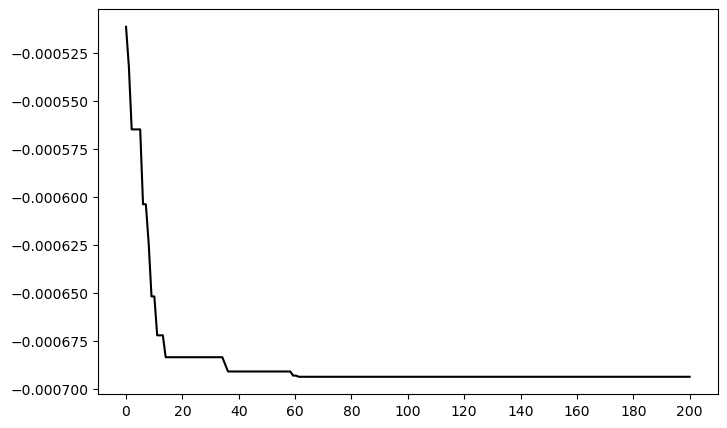

In [109]:
best_nectar= artificial_bee_colony(my_parameter, SP_mean_rtn, SP_cov_rtn, my_MR)

In [56]:
# test
# best_nectar = arrangement2(best_nectar,my_parameter,c)
# print(cal_ann_return_risk(best_nectar,SP_mean_rtn,SP_cov_rtn))
# print(result_by_iter)
# print(best_nectar.chromosome)
# print(best_nectar.dv)
# print(sum(best_nectar.dv))

In [115]:
def main(mean_rtn,cov_rtn):
    """main function"""
    
    ef_set = []
    # ABC parameter 100 assets
    my_population = int(20 * np.sqrt(100))
    my_MCN = int(200 * 100 / my_population)
    my_MR = 0.8
    num_of_rap = 40
    risk_averse_para_set = np.linspace(0.001,1,num_of_rap)
    
    for i in range(num_of_rap):
        my_parameter = ParameterInformation(my_population,100,0.001,0.4,50,my_MCN,risk_averse_para_set[i],15,50)
        
        best_nectar = artificial_bee_colony(my_parameter, SP_mean_rtn, SP_cov_rtn, my_MR)
        result = cal_ann_return_risk(best_nectar,mean_rtn,cov_rtn)
        ef_set.append(result)
    return ef_set

Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 100
Risk Averse Parameter: 0.001


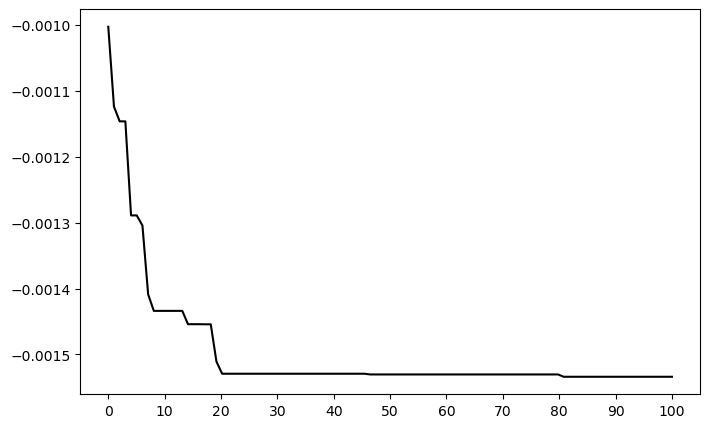

Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 100
Risk Averse Parameter: 0.026615384615384617


In [ ]:
ef_set = main(SP_mean_rtn,SP_cov_rtn)

In [56]:
%store ef_set

Stored 'ef_set' (list)


In [98]:
ef_set

[array([0.41134079, 0.26214553]),
 array([0.193435  , 0.15188548]),
 array([0.41164039, 0.26249507]),
 array([0.41140945, 0.26180168]),
 array([0.22798602, 0.16092525]),
 array([0.41123409, 0.26196247]),
 array([0.41020062, 0.26169327]),
 array([0.41148157, 0.26182167]),
 array([0.21205628, 0.17416174]),
 array([0.41154675, 0.26216246]),
 array([0.41163274, 0.26145119]),
 array([0.40864126, 0.24622186]),
 array([0.40669466, 0.24008455]),
 array([0.40774853, 0.24053607]),
 array([0.40496303, 0.23028506]),
 array([0.40435443, 0.22832956]),
 array([0.37020334, 0.27754873]),
 array([0.4017133 , 0.22026563]),
 array([0.40191974, 0.22143791]),
 array([0.40223902, 0.2324027 ]),
 array([0.40017334, 0.21585652]),
 array([0.40647429, 0.24971627]),
 array([0.3956891 , 0.20740826]),
 array([0.39598307, 0.20789593]),
 array([0.38906774, 0.19991976]),
 array([0.39457049, 0.20724059]),
 array([0.3869719 , 0.19535979]),
 array([0.38307686, 0.19243527]),
 array([0.37363393, 0.17947225]),
 array([0.3694

In [54]:
ef_set
df = pd.DataFrame(ef_set,columns=['abc-return','abc-risk'])
df.to_csv('abc-ef.csv',index = False)

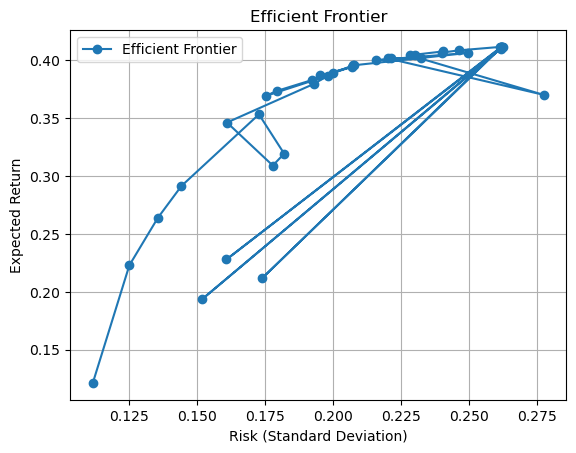

In [99]:
draw_ef(ef_set)

In [80]:
def draw_ef(ef_set):
    """
    绘制效率前沿图。
    
    参数:
    ef_set (list of lists): 每个元素是一个包含[收益, 风险]的列表。
    """
    # 分解 ef_set 列表以获取单独的收益和风险列表
    returns = [item[0] for item in ef_set]
    risks = [item[1] for item in ef_set]

    # 创建图形和坐标轴
    fig, ax = plt.subplots()

    # 绘制风险和收益点
    ax.plot(risks, returns, 'o-', label='Efficient Frontier')  # 使用圆点和线连接的方式绘制

    # 设置图形的标题和坐标轴的标签
    ax.set_title('Efficient Frontier')
    ax.set_xlabel('Risk (Standard Deviation)')
    ax.set_ylabel('Expected Return')

    # 添加图例
    ax.legend()

    # 启用网格
    ax.grid(True)

    # 显示图形
    plt.show()

In [346]:
def cal_ann_return_risk(weight, mean_rtn, cov_rtn):
    """calculate annual return and risk"""
    ann_rtn = np.dot(weight, mean_rtn) * 252  # trading days: 252
    ann_risk = np.sqrt(np.dot(np.dot(weight, cov_rtn),weight.T) * 252)
    result = np.array([ann_rtn.item(),ann_risk])
    return result